In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("./competitive-data-science-predict-future-sales"))

['mock_data.csv', '.DS_Store', 'sales_train.csv', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [2]:
sales = pd.read_csv("./competitive-data-science-predict-future-sales/mock_data.csv")

In [3]:
import datetime
sales.date = sales.date.apply(lambda x:datetime.datetime.strptime(x, "%d.%m.%Y"))
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
date            1048575 non-null datetime64[ns]
audience        1048575 non-null int64
billboard_id    1048575 non-null int64
count           1048575 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 32.0 MB


In [4]:
sales.head()

,date,audience,billboard_id,count
0,2013-01-02,59,22154,999.00
1,2013-01-03,25,2552,899.00
2,2013-01-05,25,2552,899.00
3,2013-01-06,25,2554,1709.05
4,2013-01-15,25,2555,1099.00


In [5]:
import matplotlib.pyplot as plt

In [6]:
sales = sales.iloc[:,1:]
sales = sales.reset_index(drop=True)
X = sales.dropna().drop(["count"], axis=1)

In [7]:
X.head()

,audience,billboard_id
0,59,22154
1,25,2552
2,25,2552
3,25,2554
4,25,2555


In [8]:
y = sales.dropna().drop(["audience", "billboard_id"], axis=1)
y.head()

,count
0,999.00
1,899.00
2,899.00
3,1709.05
4,1099.00


In [9]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

In [10]:
def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

In [11]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
from sklearn.model_selection import TimeSeriesSplit
ts_cross_val = TimeSeriesSplit(n_splits=5)

In [13]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_mean_squared_error")

In [14]:
cv

array([-1188647.39507695, -1097624.81040127,  -926765.53108846,
       -1129909.48206509, -1136811.47838033])

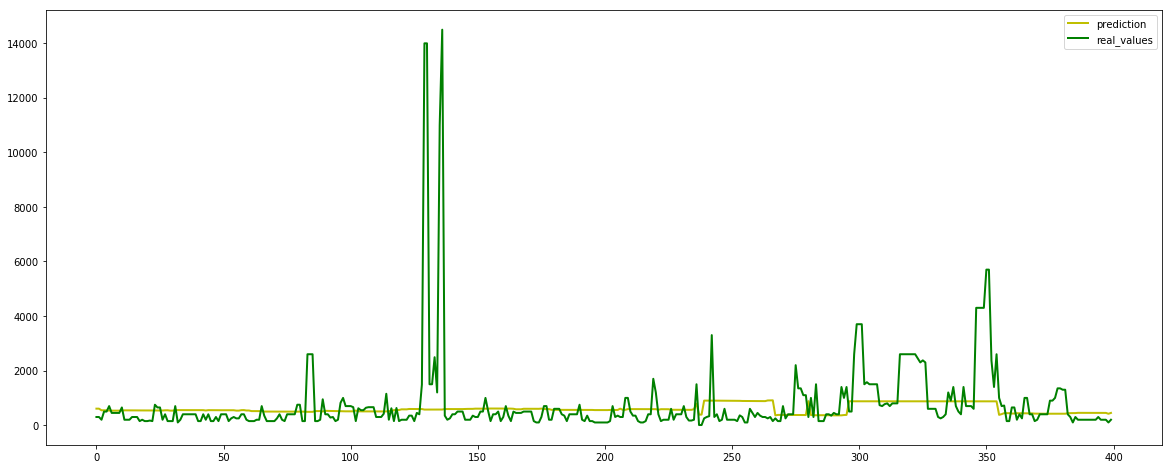

In [15]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test[-400:]), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values[-400:], "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")